In [128]:
import pandas as pd
import nltk
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, SimpleRNN
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from collections import Counter
import pickle

In [129]:
def load_datasets():
    train = pd.read_table("../datasets/ritxt/train.txt", delimiter=";", header=None)
    val = pd.read_table("../datasets/ritxt/val.txt", delimiter=";", header=None)
    test = pd.read_table("../datasets/ritxt/test.txt", delimiter=";", header=None)
    generated = pd.read_table("../datasets/ritxt/generated.txt", delimiter=";", header=None)

    train.columns = ["Text", "Emotion"]
    val.columns = ["Text", "Emotion"]
    test.columns = ["Text", "Emotion"]
    generated.columns = ["Text", "Emotion"]

    data = pd.concat([train, val, test, generated], ignore_index=True)
    data.columns = ["text", "label"]

    data = pd.concat([train, val, test, generated], ignore_index=True)
    data.columns = ["text", "label"]
    emotion_counts = data['label'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, hue=emotion_counts.index, palette='viridis', legend=False)
    plt.title('Distribution of Emotions', fontsize=16)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Records', fontsize=12)
    plt.show()

    return train, val, test, data

In [130]:
def preprocess_text(text, lemmatizer=None):
    review = re.sub("[^a-zA-Z]", " ", text)
    review = review.lower()
    review = review.split()
    stop_words = set(stopwords.words("english"))

    if lemmatizer:
        review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    else:
        review = [PorterStemmer().stem(word) for word in review if word not in stop_words]

    return " ".join(review)

In [131]:
def filter_low_frequency_words(train, val, test, threshold=2):
    all_text = " ".join(train["text"].tolist() + val["text"].tolist() + test["text"].tolist())
    word_freq = Counter(all_text.split())

    for df in [train, val, test]:
        df["text"] = df["text"].apply(
            lambda x: " ".join([word for word in x.split() if word_freq[word] >= threshold])
        )
    return train, val, test

In [132]:
def prepare_data(train, val, test, tokenizer, max_len=100):
    tokenizer.fit_on_texts(train["text"])

    X_train = tokenizer.texts_to_sequences(train["text"])
    X_val = tokenizer.texts_to_sequences(val["text"])
    X_test = tokenizer.texts_to_sequences(test["text"])

    X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
    X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

    y_train = np.array(train["N_label"])
    y_val = np.array(val["N_label"])
    y_test = np.array(test["N_label"])

    return X_train, X_val, X_test, y_train, y_val, y_test

In [133]:
def build_and_compile_model(vocab_size, embedding_dim, max_len, num_classes):
    model = Sequential(name="Text_Emotion_RNN")
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(SimpleRNN(128, return_sequences=True, activation="tanh"))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(64, activation="tanh"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation="softmax"))

    optimizer = Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [134]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


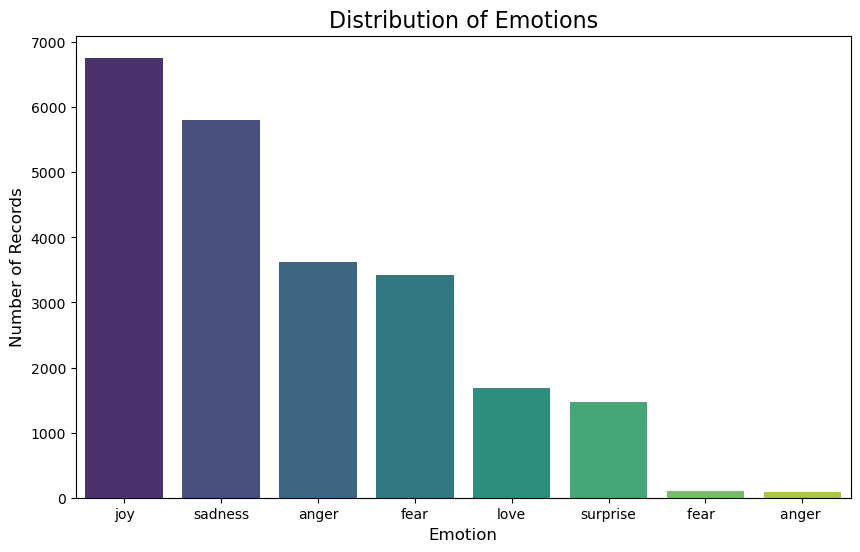

c:\Users\10\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.2730 - loss: 1.7043 - val_accuracy: 0.3570 - val_loss: 1.5726
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3387 - loss: 1.5789 - val_accuracy: 0.5415 - val_loss: 1.1748
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.5817 - loss: 1.1047 - val_accuracy: 0.6945 - val_loss: 0.8435
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.7682 - loss: 0.6925 - val_accuracy: 0.7680 - val_loss: 0.6819
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8399 - loss: 0.5114 - val_accuracy: 0.7930 - val_loss: 0.6353
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8748 - loss: 0.3978 - val_accuracy: 0.8190 - val_loss: 0.6194
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8906 - loss: 0.3403 - val_accuracy: 0.8390 - val_loss: 0.5871
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9144 - loss: 0.2838 - 

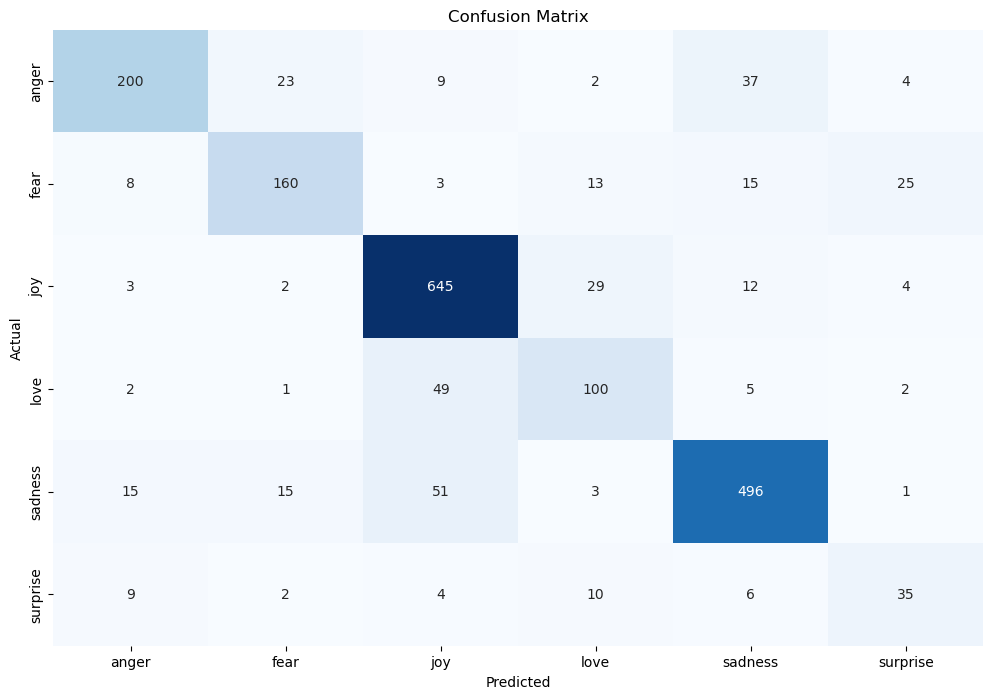

              precision    recall  f1-score   support

       anger       0.84      0.73      0.78       275
        fear       0.79      0.71      0.75       224
         joy       0.85      0.93      0.89       695
        love       0.64      0.63      0.63       159
     sadness       0.87      0.85      0.86       581
    surprise       0.49      0.53      0.51        66

    accuracy                           0.82      2000
   macro avg       0.75      0.73      0.74      2000
weighted avg       0.82      0.82      0.82      2000



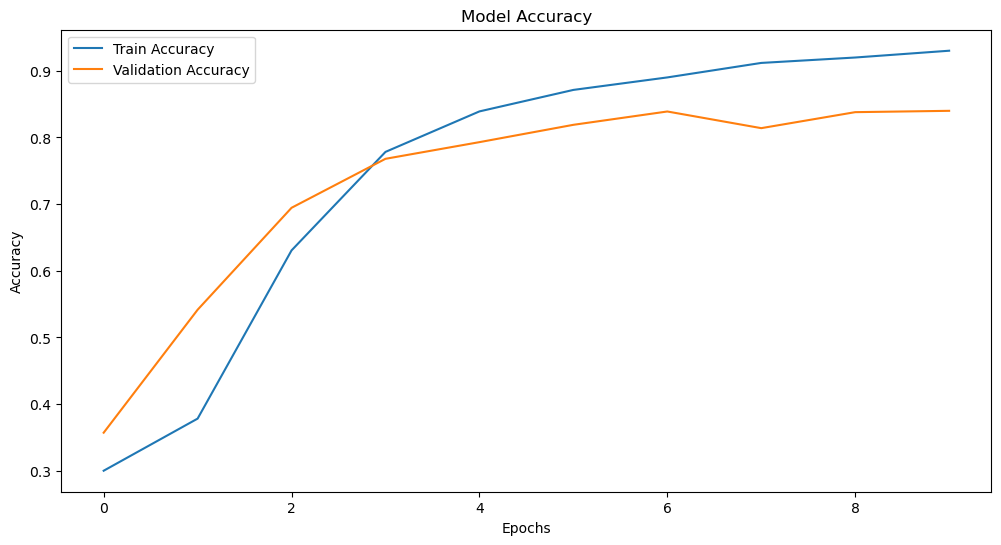

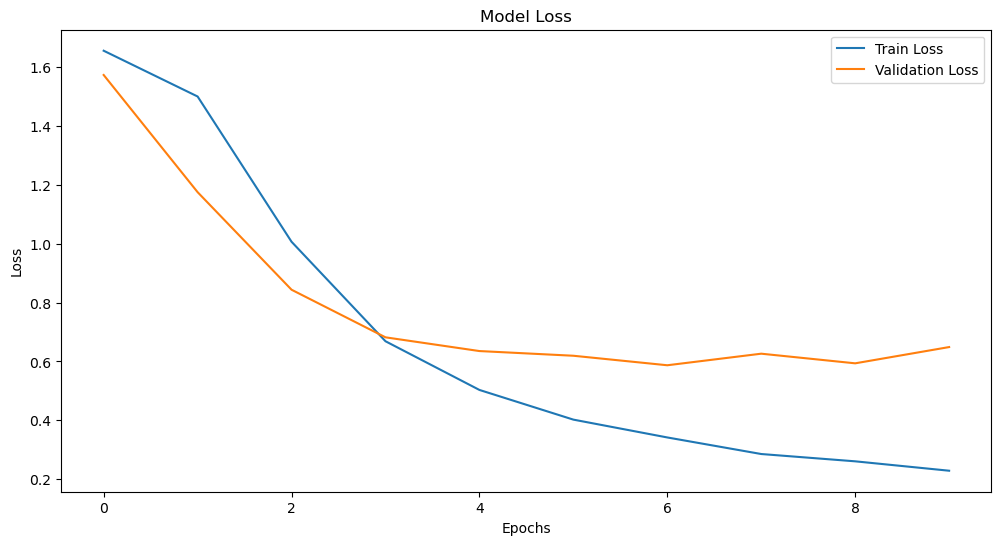

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8190 - loss: 0.6697


Test Accuracy: 81.80%


In [135]:
def main():
    train, val, test, data = load_datasets()

    lemmatizer = WordNetLemmatizer()
    train["text"] = train["Text"].apply(lambda x: preprocess_text(x, lemmatizer))
    val["text"] = val["Text"].apply(lambda x: preprocess_text(x, lemmatizer))
    test["text"] = test["Text"].apply(lambda x: preprocess_text(x, lemmatizer))

    train, val, test = filter_low_frequency_words(train, val, test)

    label_encoder = preprocessing.LabelEncoder()
    train["N_label"] = label_encoder.fit_transform(train["Emotion"])
    val["N_label"] = label_encoder.transform(val["Emotion"])
    test["N_label"] = label_encoder.transform(test["Emotion"])

    max_len = 100
    tokenizer = Tokenizer(num_words=5000)
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(train, val, test, tokenizer, max_len)

    model = build_and_compile_model(vocab_size=5000, embedding_dim=128, max_len=max_len, num_classes=len(label_encoder.classes_))

    train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder)

    model.save("../exported_files/rnn.h5")
    with open("../exported_files/rnn_tokenizer.pkl", "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("../exported_files/rnn_label_encoder.pkl", "wb") as handle:
        pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


if __name__ == "__main__":
    main()